Current learning rate: [0.001]
Epoch 1/100 | Train Loss: 0.2421 | Val Loss: 0.1755
Current learning rate: 0.001
💾 Best model saved.
Epoch 2/100 | Train Loss: 0.1835 | Val Loss: 0.1785
Current learning rate: 0.001
Epoch 3/100 | Train Loss: 0.1749 | Val Loss: 0.1884
Current learning rate: 0.001
Epoch 4/100 | Train Loss: 0.1690 | Val Loss: 0.1958
Current learning rate: 0.001
Epoch 5/100 | Train Loss: 0.1633 | Val Loss: 0.2074
Current learning rate: 0.001
Epoch 6/100 | Train Loss: 0.1606 | Val Loss: 0.2011
Current learning rate: 0.001
Epoch 7/100 | Train Loss: 0.1563 | Val Loss: 0.2037
Current learning rate: 0.0001
Epoch 8/100 | Train Loss: 0.1416 | Val Loss: 0.2067
Current learning rate: 0.0001
Epoch 9/100 | Train Loss: 0.1387 | Val Loss: 0.2157
Current learning rate: 0.0001
Epoch 10/100 | Train Loss: 0.1371 | Val Loss: 0.2145
Current learning rate: 0.0001
Epoch 11/100 | Train Loss: 0.1356 | Val Loss: 0.2211
Current learning rate: 0.0001
⚠️ Early stopping triggered. No improvement in vali

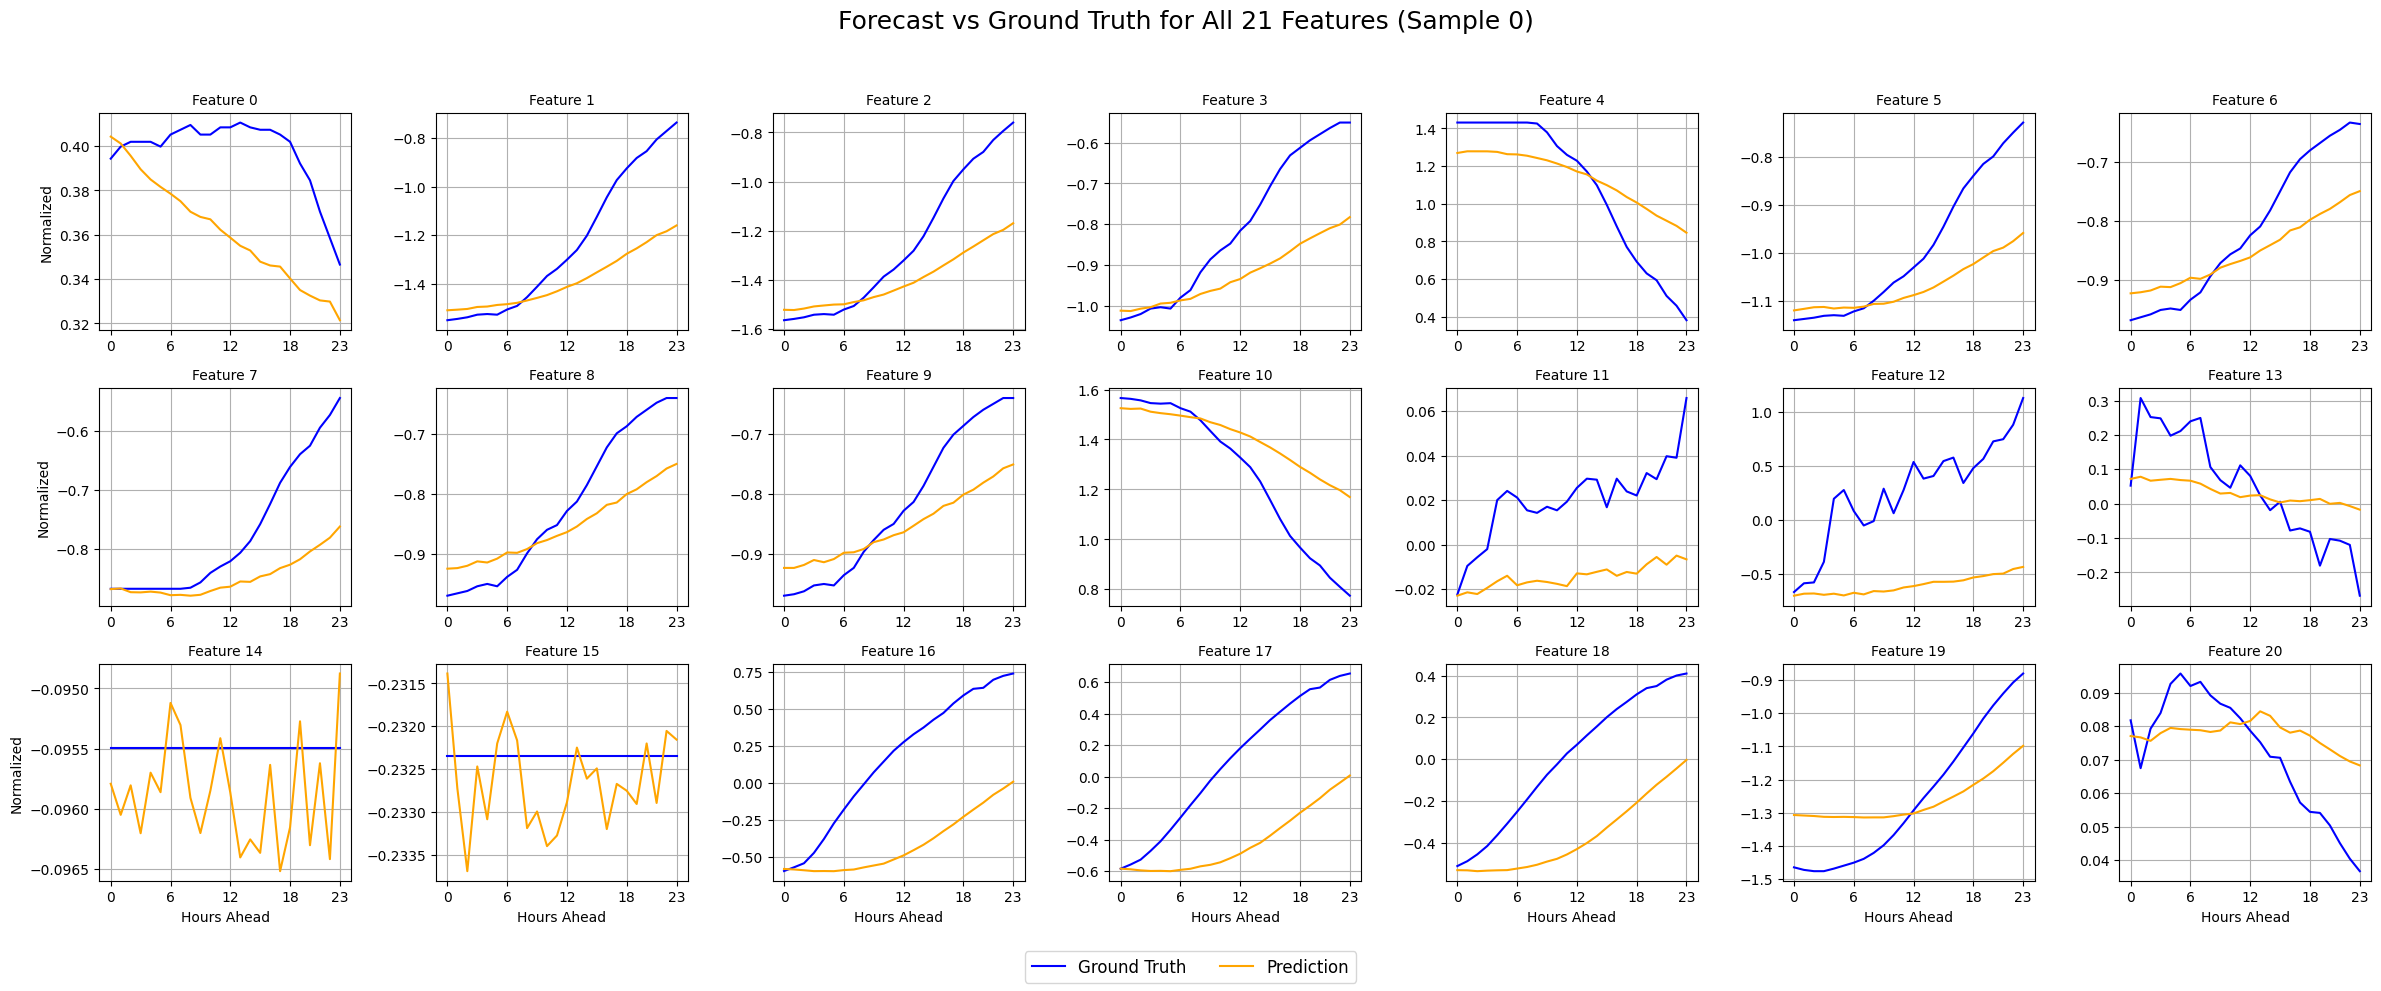

✅ Tuned model saved as lstm_weather_model_tuned.pth


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Load and Prepare Data
# ---------------------------
df = pd.read_csv('Weather.csv')
df['date'] = pd.to_datetime(df['date'])
data = df.drop(columns=['date'])

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = np.array(data_scaled, dtype=np.float32)

# ---------------------------
# Step 2: Sliding Window for Sequence Creation
# ---------------------------
def create_sliding_window_sequences(data, input_len=96, output_len=24, stride=1):
    """
    Creates sliding window sequences from the data.
    """
    X, y = [], []
    for i in range(0, len(data) - input_len - output_len, stride):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

INPUT_LEN = 96  # 16 hours
OUTPUT_LEN = 24  # 4 hours

# Create sliding window sequences
X, y = create_sliding_window_sequences(data_scaled, input_len=INPUT_LEN, output_len=OUTPUT_LEN)

# Split data into train, validation, and test sets using a sliding window approach
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# ---------------------------
# Step 3: Dataset and DataLoader
# ---------------------------
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(WeatherDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(WeatherDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(WeatherDataset(X_test, y_test), batch_size=64)

# ---------------------------
# Step 4: LSTM Model with Bidirectional LSTM and Dropout
# ---------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_len, output_size, dropout=0.2):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size * 2, output_len * output_size)  # Account for bidirectionality
        self.output_len = output_len
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last time step output
        out = self.linear(out)
        return out.view(-1, self.output_len, self.output_size)

# ---------------------------
# Step 5: Training + Validation with MAE Loss and L2 Regularization, Early Stopping, and Learning Rate Scheduler
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size=21, hidden_size=128, num_layers=2,
                     output_len=OUTPUT_LEN, output_size=21, dropout=0.3).to(device)

# Use MAE Loss instead of MSE
criterion = nn.L1Loss()  # Mean Absolute Error (MAE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # L2 regularization

# Learning Rate Scheduler (reduce lr on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
current_lr = scheduler.get_last_lr()
print("Current learning rate:", current_lr)

EPOCHS = 100
patience = 10  # Early stopping patience
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)
    print("Current learning rate:", scheduler.optimizer.param_groups[0]['lr'])

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        print("💾 Best model saved.")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⚠️ Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            break

# ---------------------------
# Step 6: Test Evaluation
# ---------------------------
model.eval()
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item()

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"\n🧪 Test Loss: {avg_test_loss:.4f}")

# ---------------------------
# Step 7: Plot Predictions vs Ground Truth
# ---------------------------

# Generate comparison plots for all 21 features
num_features = 21
sample_idx = 0  # Change this to see other sample predictions

# Concatenate predictions and targets across batches
preds_arr = np.concatenate(all_preds, axis=0)    # Shape: [num_samples, output_len, num_features]
targets_arr = np.concatenate(all_targets, axis=0)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(24, 10))
fig.suptitle(f"Forecast vs Ground Truth for All 21 Features (Sample {sample_idx})", fontsize=18)

for i in range(num_features):
    row = i // 7
    col = i % 7
    ax = axes[row, col]

    ax.plot(range(OUTPUT_LEN), targets_arr[sample_idx, :, i], label='Ground Truth', color='blue')
    ax.plot(range(OUTPUT_LEN), preds_arr[sample_idx, :, i], label='Prediction', color='orange')

    ax.set_title(f"Feature {i}", fontsize=10)
    ax.set_xticks([0, 6, 12, 18, 23])
    ax.grid(True)

    if row == 2:
        ax.set_xlabel("Hours Ahead")
    if col == 0:
        ax.set_ylabel("Normalized")

# Add a shared legend from the first subplot (consistent across all)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

# Adjust layout to fit legend and title
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# ---------------------------
# Step 8: Save & Load Model
# ---------------------------
torch.save(model.state_dict(), "lstm_weather_model_tuned.pth")
print("✅ Tuned model saved as lstm_weather_model_tuned.pth")

# To load later:
# model.load_state_dict(torch.load("lstm_weather_model_tuned.pth"))
# model.eval()